In [19]:
from collections import defaultdict
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np 
import pickle
import requests


## Cryptozombies

The CryptoPunks are a collection of 24x24, 8-bit-style pixel art images of misfits and eccentrics. There are exactly 10,000 of them, each with their own ostensible personality and unique combination of distinctive, randomly generated features.

## Load a single punk and inspect data

In [2]:
data_dir = "/home/david/artwork/zombiepunx/data"
punk_dir = f"{data_dir}/punx/images/training";


In [3]:
def get_punk(id):
    return mpimg.imread(f"""{punk_dir}/punk{"%04d" % id}.png""")

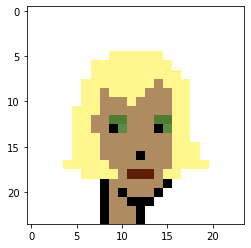

In [4]:
# Read Images
img = get_punk(0)
plt.imshow(img)

In [5]:
def colorkey_to_img(key):
    """take a color key of format
       ""[0.37254903 0.11372549 0.03529412 1.        ]"
       and return a 24 * 24 size image containing only 
       that color pixels.
    """
    (x,y) = (24,24)   
    c = np.fromstring(key[1:-1], float, sep=' ')
    return np.full((x, y, 4), c)

## Prepare Training Data

The Punks are stored as 3D Numpy Arrays. The images can be compressed into a format that is more useful in machine learning by mapping pixel RGBY pixel values to an 8 bit integer that can be used in training and eventuallly converted back for display. 

#### Step 1. Generate Pixel Map of unique values to 8 bit encoding. 

In [6]:
def flatten(img): 
  """convert (x,y,z) array containing a pixel in z-dimension 
     to an (x,y) array with str values for each (i,j)
     the intention is to make this easier to work with in ML
     training.
  """
  return np.array([[str(c) for c in row] 
                   for row in img])

def unflatten(img):
  """return a flattend image to valid .png format for display
  """  
  return np.array([[np.fromstring(c[1:-1], float, sep=' ') 
                    for c in row] for row in img])

### test flatten -> unflatten

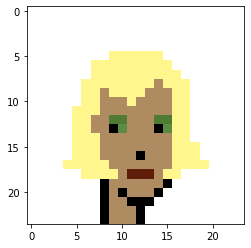

In [7]:
x = flatten(img)
y = unflatten(x)
plt.imshow(y)

### Step 2. Convert punk to 8 bit representation

#### 2.1 Find all unique values and built a translation map

In [9]:
np.unique(x)

array(['[0. 0. 0. 0.]', '[0. 0. 0. 1.]',
       '[0.3137255 0.4862745 0.2       1.       ]',
       '[0.3647059  0.54509807 0.2627451  1.        ]',
       '[0.37254903 0.11372549 0.03529412 1.        ]',
       '[0.68235296 0.54509807 0.38039216 1.        ]',
       '[1.        0.9647059 0.5568628 1.       ]'], dtype='<U45')

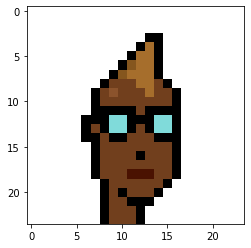

In [10]:
p_9999 = get_punk(9999)
plt.imshow(p_9999)

### Generate Map

Convert each string representation of the pixel to a unique 8 bit integer value. Naively, build the map(string->int8) and then run through all values in a conversion pass.

In [11]:
# load _colors from pickled file on disk
with open(f"{data_dir}/_colors_count.pickle", 'rb') as filehandler: 
    _colors = pickle.load(filehandler)

In [ ]:
# this is expensive - do not run by default, load from pickle file

n=10000
_colors=defaultdict(list)
for i in range(0,n):
  flatPunk = flatten(get_punk(i))
  colors = np.unique(flatPunk)
  for c in colors:
    _colors[c].append(i)
    
with open(f"{data_dir}/_colors_count.pickle", 'wb') as filehandler:
    pickle.dump(_colors, filehandler)
#type(_colors) == defaultdict

In [ ]:
_colors

In [41]:
_colors['[0. 0. 0. 1.]'] = [2]
_colors['[0. 0. 0. 1.]'].append(3)
_colors['[0. 0. 0. 1.]']

[2, 3]

store this to disk for use later. expensive to compute

peek at _colors. true to from, the cryptopunks are composed of 222 unique colors; these will fit in an an 8 bit int for training.

In [30]:
sorted_tuples = sorted(_colors.items(), key=lambda item: len(item[1]))
sorted_dict = {k: v for k, v in sorted_tuples}
sorted_dict

{'[0. 0. 0. 0.]': [9999],
 '[0. 0. 0. 1.]': [9999],
 '[0.3137255 0.4862745 0.2       1.       ]': [9958],
 '[0.3647059  0.54509807 0.2627451  1.        ]': [9958],
 '[0.37254903 0.11372549 0.03529412 1.        ]': [9974],
 '[0.68235296 0.54509807 0.38039216 1.        ]': [9998],
 '[1.        0.9647059 0.5568628 1.       ]': [9994],
 '[0.3372549  0.14901961 0.         1.        ]': [9989],
 '[0.44313726 0.24705882 0.11372549 1.        ]': [9999],
 '[0.44705883 0.21568628 0.03529412 1.        ]': [9989],
 '[0.52156866 0.3372549  0.11764706 1.        ]': [9999],
 '[0.54509807 0.3254902  0.17254902 1.        ]': [9999],
 '[0.6509804  0.43137255 0.17254902 1.        ]': [9999],
 '[0.44313726 0.0627451  0.0627451  1.        ]': [9995],
 '[0.8235294 0.6156863 0.3764706 1.       ]': [9996],
 '[0.85882354 0.69411767 0.5019608  1.        ]': [9996],
 '[0.40784314 0.23529412 0.03137255 1.        ]': [9976],
 '[0.5019608  0.85882354 0.85490197 1.        ]': [9999],
 '[0.52156866 0.31764707 0.07843

plt.bar(list(_colors.keys()), _colors.values(), color='g')
plt.show()

Many of the colors are only used once or twice. We'll keep these for now, but future work to improve the model by benefit from grouping similar tones.  

### Explore the Color Punks Palette

Generate a color pallete of pixels starting from least frequently used.

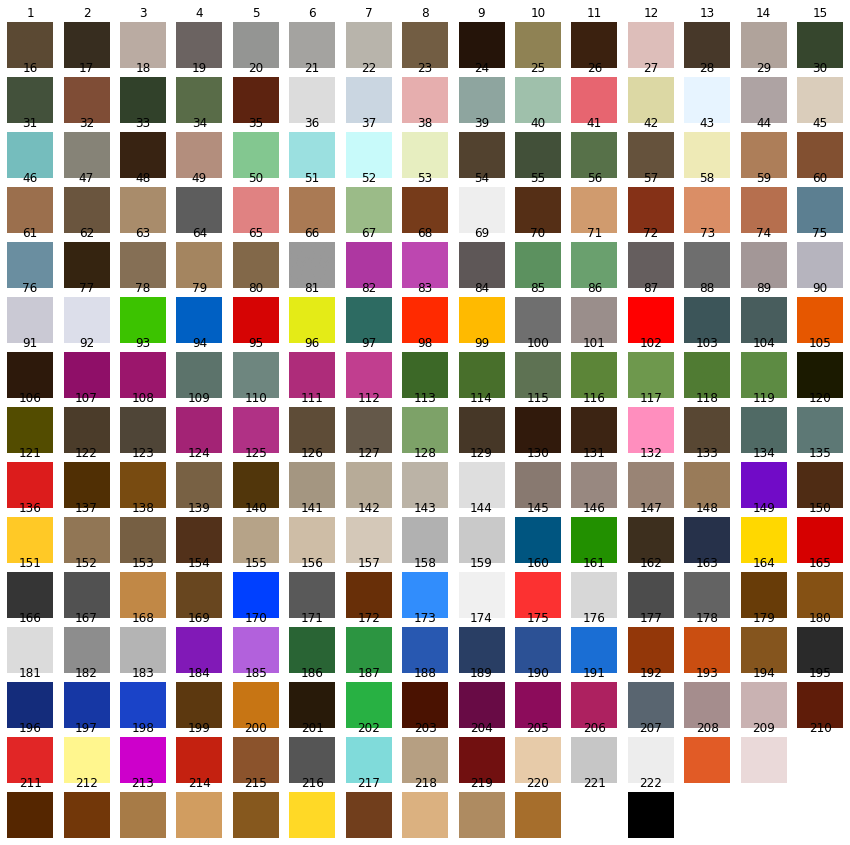

In [138]:
n=15  # n=15 will show the complete cryptopunks pallette.
bottom=list(sorted_dict.keys())[0:(n*n)]
bottom_imgs = {i:colorkey_to_img(i) for i in bottom}

(x,y) = (n,n)
# create figure
fig = plt.figure(figsize=(x,y))

i=1
for k in bottom_imgs.keys():
    fig.add_subplot(x, y, i)
    plt.imshow(bottom_imgs[k])
    plt.axis('off')
    plt.title(i)
    i=i+1

Whle there are some similar pixels, they aren't grouped as I had expected initally. At this time, reducing dimensionality through pixel consolidation is probably way too premature of an optimization.